<a href="https://colab.research.google.com/github/bmadnankece/ImageProcessingExercies/blob/master/seir_tur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mape (vaka): 0.6427533650587213
Mape (olum): 2.7742904099808596
 248962.304304
 251412.191059
 253815.046340
 256147.147357
 258415.261343
 260640.888069
 262832.293876
 264988.914282
 267101.353977
 269151.392037
 271133.108545
 273067.646201
 274966.139128
 276831.662430
 278659.232197
 280435.805501
 282142.864249
 283790.689519
 285399.697880
 286979.958093
 288532.273305
 290048.181045
 291509.953225
 292898.674568
 294236.443018
 295544.353288
 296831.478008
 298095.903766
 299324.731110
 300494.074550
 301605.765182
 302686.677137
 303736.658559
Validation MSLE: 0.00051, using Hill decay, Reproduction number(R0) : 3.40593, Fatal rate : 0.02445, K : 1.00000, L: 54.46693


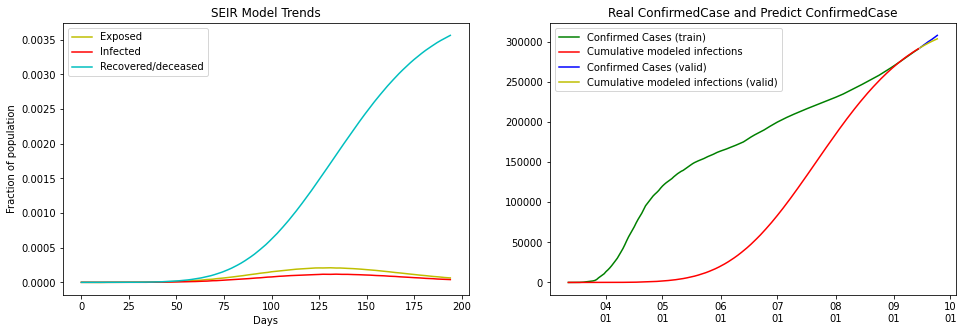

In [ ]:
import datetime
from datetime import timedelta
import matplotlib
matplotlib.get_backend()
matplotlib.get_backend()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.optimization import inline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from matplotlib import dates
import plotly.graph_objects as go
from tqdm.notebook import tqdm


# Function code refernece from https://www.kaggle.com/anjum48/seir-model-with-intervention

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc ** -1) * E


# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc ** -1) * E - (T_inf ** -1) * I


# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf ** -1) * I


def SEIR_model(t, y, R_t, T_inf, T_inc):
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t

    S, E, I, R = y

    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)

    return [S_out, E_out, I_out, R_out]

T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period

train = pd.read_csv("/content/train_tur.csv")
test = pd.read_csv('/content/test_tur.csv')
train['Date_datetime'] = train['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%d.%m.%Y')))


pop_info = pd.read_csv("/content/population_data.csv")
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

def cumsum_signal(vec):
    temp_val = 0
    vec_new = []
    for i in vec:
        if i > temp_val:
            vec_new.append(i)
            temp_val = i
        else:
            vec_new.append(temp_val)
    return vec_new


# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr = params  # Paramaters, R0 and cfr
    N = population  # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0]  # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days  # How many days want to predict
    s, e, i, r = (N - n_infected) / N, 0, n_infected / N, 0  # Initial stat for SEIR model

    # R0 become half after intervention days
    def time_varying_reproduction(t):
        if t > 80:  # we set intervention days = 80
            return R_0 * 0.5
        else:
            return R_0

    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))

    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N, 0, np.inf)
    y_true_cases = data['ConfirmedCases'].values

    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec * N * cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values

    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days + 1)[::-1]  # Recent data is more heavily weighted

    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])

    if return_solution:
        return msle_final, sol
    else:
        return msle_final


# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, cfr, k, L = params  # Paramaters, R0 and cfr
    N = population  # Population of each country
    n_infected = data['ConfirmedCases'].iloc[0]  # start from first comfirmedcase on dataset first date
    max_days = len(data) + forecast_days  # How many days want to predict
    s, e, i, r = (N - n_infected) / N, 0, n_infected / N, 0  # Initial stat for SEIR model

    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t):
        return R_0 / (1 + (t / L) ** k)

    # Solve the SEIR differential equation.
    sol = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], args=(time_varying_reproduction, T_inf, T_inc),
                    t_eval=np.arange(0, max_days))

    sus, exp, inf, rec = sol.y
    # Predict confirmedcase
    y_pred_cases = np.clip((inf + rec) * N, 0, np.inf)
    y_true_cases = data['ConfirmedCases'].values

    # Predict Fatalities by remove * fatality rate(cfr)
    y_pred_fat = np.clip(rec * N * cfr, 0, np.inf)
    y_true_fat = data['Fatalities'].values

    optim_days = min(20, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days + 1)[::-1]  # Recent data is more heavily weighted

    # using mean squre log error to evaluate
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])

    if return_solution:
        return msle_final, sol
    else:
        return msle_final


def fit_model_new(data, area_name, initial_guess=[2.2, 0.02, 2, 50],
                  bounds=((1, 20), (0, 0.15), (1, 3), (1, 100)), make_plot=True, decay_mode=None, px=None):
    if area_name in ['Turkey']:  # France last data looks weird, remove it
        train = data.query('ConfirmedCases > 0').copy()
    else:
        train = data.query('ConfirmedCases > 0').copy()

    ####### Split Train & Valid #######
    valid_data = train[-10:].copy()
    train_data = train[:-10].copy()

    ####### If this country have no ConfirmedCase, return 0 #######
    if len(train_data) == 0:
        result_zero = np.zeros((43))
        return pd.DataFrame({'ConfirmedCases': result_zero, 'Fatalities': result_zero}), 0

        ####### Load the population of area #######
    try:
        # population = province_lookup[area_name]
        population = pop_info[pop_info['Name'] == area_name]['Population'].tolist()[0]
    except IndexError:
        print('country not in population set, ' + str(area_name))
        population = 1000000

    if area_name == 'US':
        population = 327200000

    if area_name == 'Global':
        population = 7744240900

    cases_per_million = train_data['ConfirmedCases'].max() * 10 ** 6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]

    ####### Total case/popuplation below 1, reduce country population #######
    if cases_per_million < 1:
        # print ('reduce pop divide by 100')
        population = population / 100

    ####### Fit the real data by minimize the MSLE #######
    res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')

    ####### Align the date information #######
    test_end = datetime.datetime.strptime('24.09.2020', '%d.%m.%Y')
    test_start = datetime.datetime.strptime('16.07.2020', '%d.%m.%Y')
    test_period = (test_end - test_start).days
    train_max = train_data.Date_datetime.max()
    train_all_max = train.Date_datetime.max()
    train_min = train_data.Date_datetime.min()
    add_date = 0
    delta_days = (test_end - train_max).days
    train_add_time = []

    if train_min > test_start:
        add_date = (train_min - test_start).days
        last = train_min - timedelta(add_date)
        train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
        train_add_time = pd.to_datetime(train_add_time)
        dates_all = train_add_time.append(
            pd.to_datetime(np.arange(train_min, test_end + timedelta(1), dtype='datetime64[D]')))
    else:
        dates_all = pd.to_datetime(np.arange(train_min, test_end + timedelta(1), dtype='datetime64[D]'))

    ####### Auto find the best decay function #######
    if decay_mode is None:
        if res_const.fun < res_decay.fun:
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days + add_date)
            res = res_const

        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days + add_date)
            res = res_decay
            R_0, cfr, k, L = res.x
    else:
        if decay_mode == 'day_decay':
            msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days + add_date)
            res = res_const
        else:
            msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days + add_date)
            res = res_decay
            R_0, cfr, k, L = res.x

    ####### Predict the result by using best fit paramater of SEIR model #######
    sus, exp, inf, rec = sol.y

    y_pred = pd.DataFrame({
        'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
        # 'ConfirmedCases': [inf[0]*population for i in range(add_date)]+(np.clip((inf + rec) * population,0,np.inf)).tolist(),
        # 'Fatalities': [rec[0]*population for i in range(add_date)]+(np.clip(rec, 0, np.inf) * population * res.x[1]).tolist()
        'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())
    })

    y_pred_valid = y_pred.iloc[len(train_data):len(train_data) + len(valid_data)]
    # y_pred_valid = y_pred.loc[:len(train_data)]
    y_pred_test = y_pred.iloc[-(test_period + 1):]
    # y_true_valid = train_data[['ConfirmedCases', 'Fatalities']]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
    # print (len(y_pred),train_min)
    # print (y_true_valid['ConfirmedCases'])
    # print (y_pred_valid['ConfirmedCases'])
    #print(y_pred['ConfirmedCases'])
    #print(train_data['ConfirmedCases'])
    ####### Calculate MSLE #######
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    ####### Calculate MAPE-vaka#######
    # print(train['ConfirmedCases'])
    gercek = np.array(y_true_valid['ConfirmedCases'])
    tahmin = np.array(y_pred_valid['ConfirmedCases'])

    mape_seir = np.mean(np.abs((gercek - tahmin) / gercek)) * 100
    print("Mape (vaka):", mape_seir)
    ####### Calculate MAPE-olum#######
    # print(train['ConfirmedCases'])
    o_gercek = np.array(y_true_valid['Fatalities'])
    o_tahmin = np.array(y_pred_valid['Fatalities'])
    o_mape_seir = np.mean(np.abs((o_gercek - o_tahmin) / o_gercek)) * 100
    print("Mape (olum):", o_mape_seir)
    #####################3
    dfx=y_pred['ConfirmedCases']
    print(dfx.tail(n=33).to_string(index=False))
    ####### Plot the fit result of train data and forecast after 300 days #######
    if make_plot:
        if len(res.x) <= 2:
            print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')

        else:
            print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')


        ####### Plot the fit result of train data dna SEIR model trends #######

        f = plt.figure(figsize=(16, 5))
        ax = f.add_subplot(1, 2, 1)
        ax.plot(exp, 'y', label='Exposed');
        ax.plot(inf, 'r', label='Infected');
        ax.plot(rec, 'c', label='Recovered/deceased');
        plt.title('SEIR Model Trends')
        plt.xlabel("Days", fontsize=10);
        plt.ylabel("Fraction of population", fontsize=10);
        plt.legend(loc='best');
        # train_date_remove_year = train_data['Date_datetime'].apply(lambda date:'{:%m-%d}'.format(date))
        ax2 = f.add_subplot(1, 2, 2)
        xaxis = train_data['Date_datetime'].tolist()
        xaxis = dates.date2num(xaxis)
        hfmt = dates.DateFormatter('%m\n%d')
        ax2.xaxis.set_major_formatter(hfmt)
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), train_data['ConfirmedCases'],
                 label='Confirmed Cases (train)', c='g')
        ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),
                 y_pred['ConfirmedCases'][:len(train_data)], label='Cumulative modeled infections', c='r')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_true_valid['ConfirmedCases'],
                 label='Confirmed Cases (valid)', c='b')
        ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_pred_valid['ConfirmedCases'],
                 label='Cumulative modeled infections (valid)', c='y')
        plt.title('Real ConfirmedCase and Predict ConfirmedCase')
        plt.legend(loc='best');
        plt.show()
        ####### Forecast 300 days after by using the best paramater of train data #######
        if len(res.x) > 2:
            msle, sol = eval_model_decay(res.x, train_data, population, True, 300)
        else:
            msle, sol = eval_model_const(res.x, train_data, population, True, 300)

        sus, exp, inf, rec = sol.y

        y_pred = pd.DataFrame({
            'ConfirmedCases': cumsum_signal(np.diff((inf + rec) * population, prepend=n_infected).cumsum()),
            'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
        })

        ####### Plot 300 days after of each country #######
        start = train_min
        end = start + timedelta(len(y_pred))
        time_array = np.arange(start, end, dtype='datetime64[D]')

        max_day = np.where(inf == np.amax(inf))[0][0]
        where_time = time_array[max_day]
        pred_max_day = y_pred['ConfirmedCases'][max_day]
        xy_show_max_estimation = (where_time, max_day)

        con = y_pred['ConfirmedCases']
        max_day_con = np.where(con == np.amax(con))[0][0]  # Find the max confimed case of each country
        max_con = np.amax(con)
        where_time_con = time_array[len(time_array) - 50]
        xy_show_max_estimation_confirmed = (where_time_con, max_con)

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                                 mode='lines',
                                 line=dict(color='red'),
                                 name='Estimation Confirmed Case Start from ' + str(start.date()) + ' to ' + str(
                                     end.date())))

        fig.add_trace(go.Scatter(x=time_array[:len(train)], y=train['ConfirmedCases'],
                                 mode='lines',
                                 name='Confirmed case until ' + str(train_all_max.date()),
                                 line=dict(color='green', width=4)))
        fig.add_annotation(
            x=where_time_con,
            y=max_con - (max_con / 30),
            showarrow=False,
            text="Estimate Max Case around:" + str(int(max_con)),
            font=dict(
                color="Blue",
                size=15
            ))
        fig.add_annotation(
            x=time_array[len(train) - 1],
            y=train['ConfirmedCases'].tolist()[-1],
            showarrow=True,
            text=f"Real Max ConfirmedCase: " + str(int(train['ConfirmedCases'].tolist()[-1])))

        fig.add_annotation(
            x=where_time,
            y=pred_max_day,
            text='Infect start decrease from: ' + str(where_time))
        fig.update_layout(title='Estimate Confirmed Case ,' + area_name + ' Total population =' + str(int(population)),
                          legend_orientation="h")
        fig.show()

    return y_pred_test, valid_msle

country = 'Turkey'
if country not in train['Country_Region'].unique():
    country_pd_train = train[train['Province_State'] == country]
else:
    country_pd_train = train[train['Country_Region'] == country]
a, b = fit_model_new(country_pd_train, country, make_plot=True)

